# Fraud Detection Using Synthetic Financial Datasets

PaySim is a financial mobile money simulator devised for fraud detection. It is based on a sample of real transactions extracted from one month of financial logs from a mobile money service implemented in an African country.

Using this synthetic dataset, we aim to better understand the features related to mobile money transaction and enhance the accuracy of fraud detection by implementing different ML models.

Data available at [kaggle](https://www.kaggle.com/ntnu-testimon/paysim1).

In [2]:
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
sns.set_palette('Set2')

SMALL_SIZE = 10
MEDIUM_SIZE = SMALL_SIZE + 3

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes\n",
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title\n",
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels\n",
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels\n",
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels\n",
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize\n",
plt.rc('figure', titlesize=SMALL_SIZE)  # fontsize of the figure title\n",
plt.rc('figure', dpi=120)

In [3]:
paysim = pd.read_csv('../data/paysimdata.csv')
print(paysim.shape)
paysim.head()

(6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


### Fields information

* step - integer - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

* type - string/categorical - type of transaction: CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

* amount - float - amount of the transaction in local currency.

* nameOrig - string - customer who initiated the transaction

* oldbalanceOrg - float initial balance before the transaction

* newbalanceOrig - float - new balance after the transaction

* nameDest - string - customer who is the recipient of the transaction

* oldbalanceDest - float - initial balance of recipient before the transaction.

* newbalanceDest - float - new balance of recipient after the transaction.

* isFraud - boolean/binary - tells if transaction is fraudulent (encoded as 1) or valid (encoded as 0)

* isFlaggedFraud - boolean/binary - tells if transaction is flagged as fraudulent (encoded as 1) or not flagged at all (encoded as 0). An observation is flagged if the transaction is fraudulent and it involved a transfer of over 200,000 in the local currency.

In [4]:
#Check data summary

paysim.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [5]:
#Check if there are any missing values

paysim.isnull().values.sum()

0

NOTE:

* There are no missing values
* There are just over 6 million observations
* There are 11 features
* Most transactions involve amounts less than 1 million euros.
* Most observations in the dataset are of valid transactions, so any patterns related to identifying fraud transactions may be hard to see, data is also unbalanced.
* From the sample of observations, there are many instances where what happens to the recipient account (oldbalanceDest, newbalanceDest) does not make sense (e.g. the very first observation involved a payment of 9839.64 yet, the balance before and after the transaction equals 0.)

# 1. EDA

CASH_OUT    0.35
PAYMENT     0.34
CASH_IN     0.22
TRANSFER    0.08
DEBIT       0.01
Name: type, dtype: float64


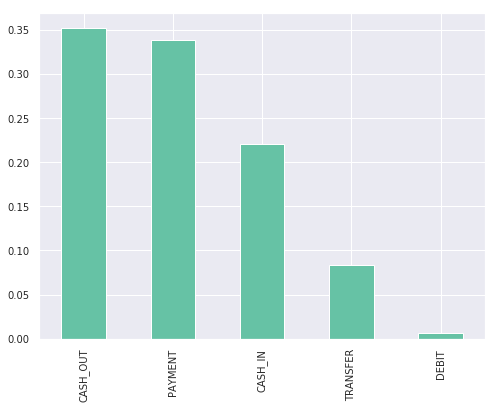

In [6]:
# Visualize different types of transactions

print(round(paysim.type.value_counts(normalize=True),2))
paysim.type.value_counts(normalize=True).plot(kind='bar', figsize=(8,6))

In [7]:
# Let's check TP, FP, TN, FN: proportion of each, how transactions look like in each case

is_fraud = paysim['isFraud']==1
is_flagged = paysim['isFlaggedFraud']==1

true_positive = paysim[is_fraud & is_flagged]
false_positive = paysim[~is_fraud & is_flagged]
true_negative = paysim[~is_fraud & ~is_flagged]
false_negative = paysim[is_fraud & ~is_flagged]

In [8]:
print(true_positive.shape)
print(false_positive.shape)
print(true_negative.shape)
print(false_negative.shape)

(16, 11)
(0, 11)
(6354407, 11)
(8197, 11)


NOTE:
- There are no false_positives
- There are many false_negatives; detection failed

### When does fraud happens?
Let's learn by studying different cases:
True positive vs. False negative vs. True negative


### 1-1. Take a look at the characteristics of the detected frauds (true positives)

In [9]:
print(f'Typical fraud transaction type(s): {true_positive.type.unique()}')

Typical fraud transaction type(s): ['TRANSFER']


In [10]:
# A function to look for names appeared in any fraudulent transaction

def get_names_with_false_amount(data):
    Difference_Orig = data['oldbalanceOrg'] - data['newbalanceOrig']
    Difference_Dest = data['oldbalanceDest'] - data['newbalanceDest']

    # If transaction amount is not equal to the difference in balances of origin
    suspicious_names = []
    if (data['amount'] != Difference_Orig).any():
        suspicious_names += [name for name in data.nameOrig if name not in suspicious_names]
        suspicious_names += [name for name in data.nameDest if name not in suspicious_names]
    print(f'Fraud alert!!!')
    return list(set(suspicious_names))


In [11]:
suspicious_names = get_names_with_false_amount(true_positive)
suspicious_names

Fraud alert!!!


['C1082139865',
 'C728984460',
 'C1892216157',
 'C1909486199',
 'C193696150',
 'C1147517658',
 'C639921569',
 'C1770418982',
 'C786455622',
 'C1806199534',
 'C1035541766',
 'C917414431',
 'C1392803603',
 'C1366804249',
 'C891140444',
 'C1684585475',
 'C1861208726',
 'C724693370',
 'C908544136',
 'C1100697970',
 'C1869569059',
 'C1395467927',
 'C661958277',
 'C1109166882',
 'C1308068787',
 'C1100582606',
 'C689608084',
 'C19004745',
 'C452586515',
 'C992223106',
 'C484597480',
 'C2140038573']

In [12]:
# A function to detect any transaction activities in which appeared these suspicious_names

def suspicious_transactions_by_name(data, names_list):
    suspicious_records = pd.DataFrame()
    for name in names_list:
        name_matched = data[(data['nameOrig']==name) | (data['nameDest']==name)]
        if (name_matched['isFraud']==1).any():
            suspicious_records = suspicious_records.append(name_matched)
    return suspicious_records

In [13]:
# Did the names used in detected frauds used in other undetected frauds?

suspicious_names_records = suspicious_transactions_by_name(false_negative, suspicious_names)
print(suspicious_names_records.shape)
suspicious_names_records

(0, 0)


""


No, the names detected in TPs were not used in other fraudulent transactions.<br>
Another approach to detect names used in frauds:<br>
From de nameOrig and nameDest columns, the input that starts with 'C' is the Customer and if starts with 'M' is the Business.<br>
So let's count the transactions by customer-recipient type: (CC,CB,BC,BB)


In [14]:
# Adding feature validTransactionType to the new df
paysim_new = paysim.copy()
paysim_new["validTransactionType"] = np.nan # Initializing new feature column

# Filling feature column
paysim_new.loc[paysim.nameOrig.str.startswith('C') & paysim.nameDest.str.startswith('C'),"validTransactionType"] = "CC" 
paysim_new.loc[paysim.nameOrig.str.startswith('C') & paysim.nameDest.str.startswith('M'),"validTransactionType"] = "CB"
paysim_new.loc[paysim.nameOrig.str.startswith('M') & paysim.nameDest.str.startswith('C'),"validTransactionType"] = "BC"
paysim_new.loc[paysim.nameOrig.str.startswith('M') & paysim.nameDest.str.startswith('M'),"validTransactionType"] = "BB"

In [15]:
# Print out the result dataframe
paysim_new.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,validTransactionType
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,CB
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,CB
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,CC
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,CC
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,CB


In [16]:
# 'is_fraud' mask created previously

fraud = paysim_new[is_fraud]
valid = paysim_new[~is_fraud]

In [17]:
# The counts of transactions by customer-recipient type (CC,CB,BC,BB)
print("Fraud transactions and customer-recipient type: \n",fraud.validTransactionType.value_counts())
print()
print("Valid transactions and customer-recipient type: \n",valid.validTransactionType.value_counts())

Fraud transactions and customer-recipient type: 
 CC    8213
Name: validTransactionType, dtype: int64

Valid transactions and customer-recipient type: 
 CC    4202912
CB    2151495
Name: validTransactionType, dtype: int64


All Fraud transactions were 'CC' type

### 1-2.  Check the false negatives and figure out why they were not detected

Typical fraud transaction type(s): ['TRANSFER' 'CASH_OUT']


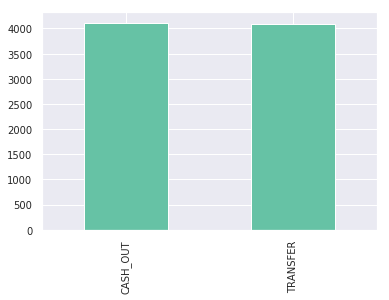

In [18]:
# What are the main transaction types of FNs?

print(f'Typical fraud transaction type(s): {false_negative.type.unique()}')
false_negative.type.value_counts().plot(kind='bar')

It makes sense that the most of fraudulent actions are 'Transfer' or 'cash out', and not, for example, 'cash in'. Thus we can create a new column to flag when a transaction was either 'Transfer' or 'Cash out'

In [19]:
type_filter = (paysim_new['type'] == 'TRANSFER')|(paysim_new['type'] == 'CASH_OUT')

# Flag the rows only if their transaction types were either transfer or cashout
paysim_new['type_to_watch']=type_filter*1

In [20]:
paysim_new.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,validTransactionType,type_to_watch
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,CB,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,CB,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,CC,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,CC,1
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,CB,0


# 2. Feature selection

### 2-1. Balance-related columns

Let's see if information on balances before & after transactions can be an indicator for a fraud behavior.

In [21]:
df_list = [true_positive, false_negative, true_negative]
df_names = ['true_positive', 'false_negative', 'true_negative']
balances = ['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

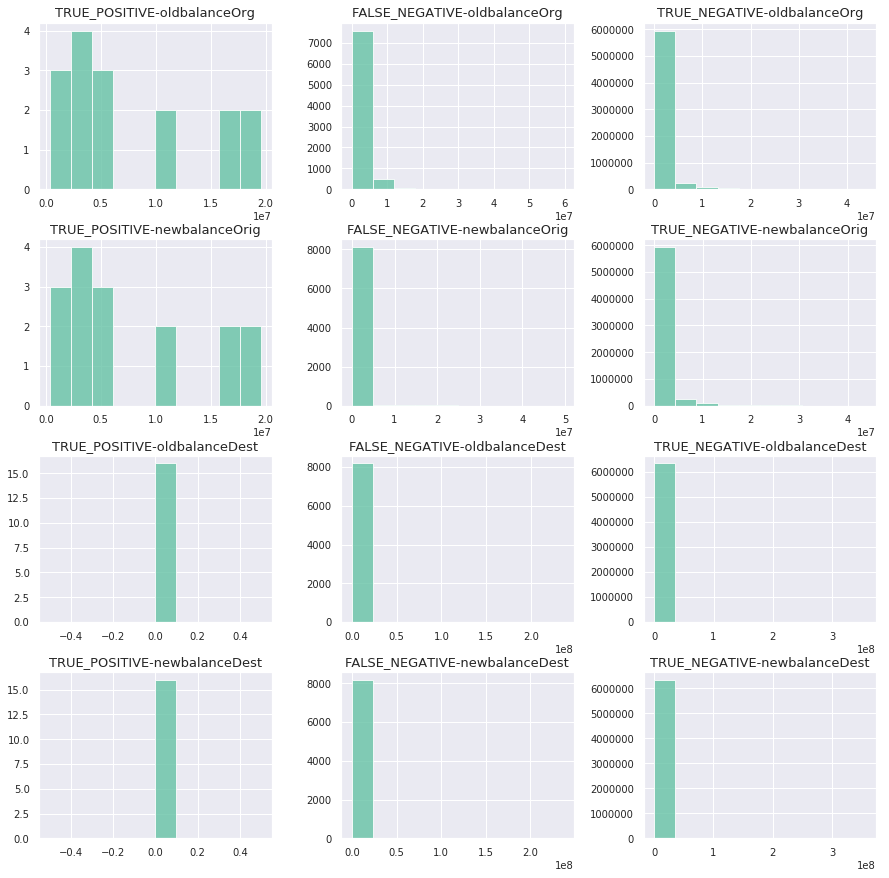

In [26]:
# Let's compare balance of customer and recipient before & after transaction
# (TP vs. FN vs. TN)

fig, ax = plt.subplots(4, 3, figsize=(15,15))
plt.subplots_adjust(hspace=.3, wspace=.3)

for i, df in enumerate(df_list):
    for j, balance in enumerate(balances):
        g=df[balance].hist(alpha=.8, ax=ax[j, i%3])
        g.set_title(df_names[i].upper()+'-'+balances[j])

plt.show()

Note:<br>
- Note that the y-axis are not uniform.
- 'Balance' columns can be a confounding feature since false_negatives have similar distribution of the values with true_negatives, rather than with true positives.
Therefore, these features can be excluded for the future modeling.

### 2-2. Transaction amount


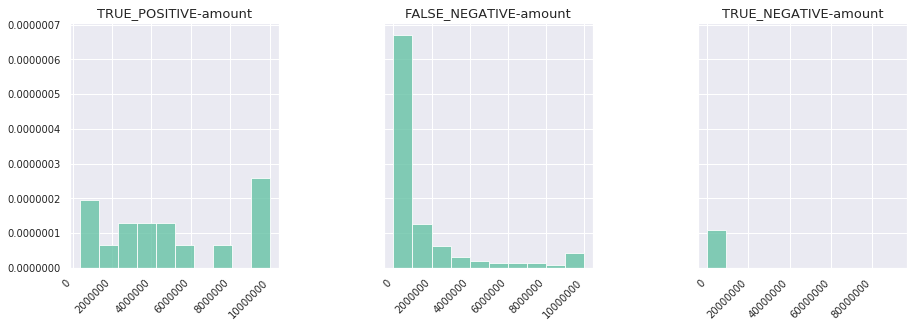

In [27]:
# Plot amount of each transaction (TP vs. FN vs. TN)

fig, ax = plt.subplots(1, 3, figsize=(15,5), sharey=True)
plt.subplots_adjust(wspace=.5)

for i, df in enumerate(df_list):
    g = df.amount.hist(alpha=.8, ax=ax[i], density=True) #Normalized histogram
    g.set_title(df_names[i].upper()+'-amount')
    g.ticklabel_format(style = 'plain')
    
fig.autofmt_xdate(rotation=45)
plt.show()

Note:<br>
Amount distribution can be used to increase the detection rate since there is a difference in distribution when it's frauduelnt and when it's not.

### 2-3. Steps of transactions

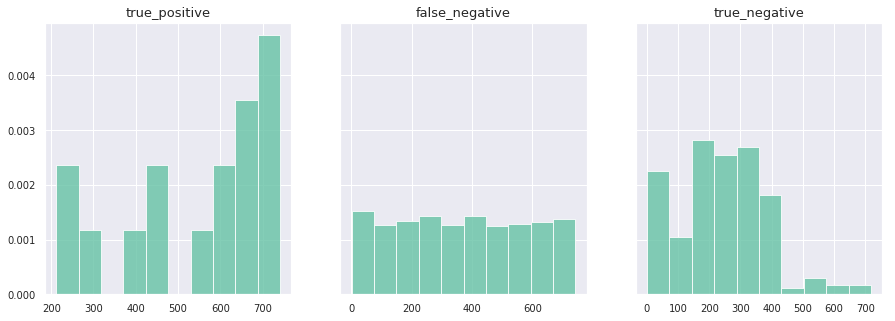

In [24]:
# Steps: a unit of time: 1 step is 1 hour of time. Total steps 744 (30 days simulation).

fig, ax = plt.subplots(1, 3, figsize=(15,5), sharey=True)

for i, df in enumerate(df_list):
    g = df.step.hist(alpha=.8, ax=ax[i], density=True) #Normalized histogram
    g.set_title(df_names[i])
plt.show()

Note: There are more fraudulent activities when step > 400. Unlike True_negatives, False_negatives were seen regularly over the steps without large variance.

### 2-4. Name of clients and recipients
We already saw that all the fraud transactions were between individuals ('CC' type)

# 3. Final features and target

In [29]:
# Previously, we defined a new dataframe with some newly introduced features

paysim_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 13 columns):
step                    int64
type                    object
amount                  float64
nameOrig                object
oldbalanceOrg           float64
newbalanceOrig          float64
nameDest                object
oldbalanceDest          float64
newbalanceDest          float64
isFraud                 int64
isFlaggedFraud          int64
validTransactionType    object
type_to_watch           int64
dtypes: float64(5), int64(4), object(4)
memory usage: 631.1+ MB


In the next step, we'll implement different machine learning algorithms to enhance the detection rate of fraud activity with this feature engineered dataset. Since our target is a binary column ('isFraud'), we're dealing with a classification problem.

For our modeling, we'll export this dataframe as a csv file.

In [31]:
paysim_new.to_csv("../data/paysim_for_ML.csv")

In [32]:
# Sanity check

paysim_for_ML = pd.read_csv("../data/paysim_for_ML.csv", index_col=0)

print(paysim_for_ML.shape)
paysim_for_ML.head()

/home/hyoj/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


(6362620, 13)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,validTransactionType,type_to_watch
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,CB,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,CB,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,CC,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,CC,1
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,CB,0
